## Convolutional AutoEncoder for CIFAR10 : PyTorch

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Step 0. Device Stepup

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cuda


Hyperparameters

In [ ]:
learning_rate = 1e-3
batch_size = 100
epochs = 20

### Step 1. Data -  target class : 10

In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=10000)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. AE Model

In [ ]:
# Step 2. Model
class CAE(torch.nn.Module):

    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
            nn.SELU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
            )

    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out


model = CAE().to(device)


### Step 3. Loss,Optimizer, Metric

In [ ]:
# Step 3. Loss and Optimizer 
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step 4. Train the model

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, X)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    print(f"Train - Avg loss: {train_loss:>8f}", end = "  ")

    return train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f"Test - Avg loss: {test_loss:>8f}")

    return test_loss

In [ ]:
train_loss = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)

    loss_t = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss_t)

print("Done!")

Epoch 1 :  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train - Avg loss: 0.020443  Test - Avg loss: 0.010569
Epoch 2 :  Train - Avg loss: 0.009362  Test - Avg loss: 0.008737
Epoch 3 :  Train - Avg loss: 0.008389  Test - Avg loss: 0.008137
Epoch 4 :  Train - Avg loss: 0.007940  Test - Avg loss: 0.007769
Epoch 5 :  Train - Avg loss: 0.007614  Test - Avg loss: 0.007463
Epoch 6 :  Train - Avg loss: 0.007351  Test - Avg loss: 0.007245
Epoch 7 :  Train - Avg loss: 0.007172  Test - Avg loss: 0.007113
Epoch 8 :  Train - Avg loss: 0.007049  Test - Avg loss: 0.007017
Epoch 9 :  Train - Avg loss: 0.006963  Test - Avg loss: 0.006955
Epoch 10 :  Train - Avg loss: 0.006905  Test - Avg loss: 0.006901
Epoch 11 :  Train - Avg loss: 0.006865  Test - Avg loss: 0.006861
Epoch 12 :  Train - Avg loss: 0.006835  Test - Avg loss: 0.006830
Epoch 13 :  Train - Avg loss: 0.006811  Test - Avg loss: 0.006807
Epoch 14 :  Train - Avg loss: 0.006791  Test - Avg loss: 0.006786
Epoch 15 :  Train - Avg loss: 0.006775  Test - Avg loss: 0.006768
Epoch 16 :  Train - Avg loss: 

### Plot the Training/Test loss

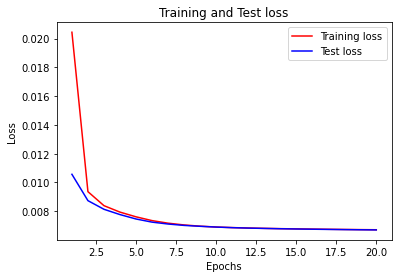

In [ ]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot images

In [ ]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")


### Show Reconstruction Images

In [ ]:
def show_reconstructions(model, dataloader=test_dataloader, n_images=5):
    with torch.no_grad():
      images, y = next(iter(dataloader))
      reconstructions = model(images[:n_images].to(device)).cpu()

    print(images.shape, reconstructions.shape)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(np.transpose(images[image_index], (1, 2, 0)))
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(np.transpose(reconstructions[image_index], (1, 2, 0)))


### Show Original and Reconstruected Images

torch.Size([10000, 3, 32, 32]) torch.Size([5, 3, 32, 32])


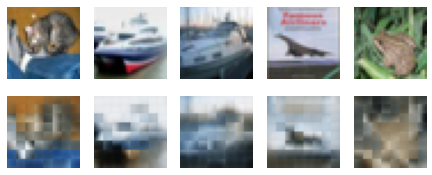

In [ ]:
show_reconstructions(model, test_dataloader, 5)

In [ ]:
### Step 5. Test the Model

In [ ]:
with torch.no_grad():
  x_test, y_test = next(iter(test_dataloader))
  X_test = x_test.to(device)
  X_test_compressed = model.encoder(X_test).cpu()

X_test = X_test.squeeze().cpu()
y_test = y_test.cpu()
print(X_test.shape, y_test.shape, X_test_compressed.shape)

X_test_compressed = X_test_compressed.reshape(-1, 4*8*8)
print(X_test_compressed.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 4, 8, 8])
torch.Size([10000, 256])


### Image Visualization with TSNE

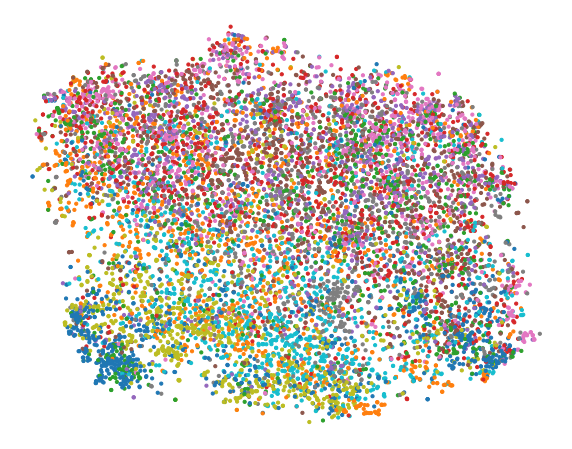

In [ ]:
tsne = TSNE()
X_test_2D = tsne.fit_transform(X_test_compressed)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

plt.figure(figsize=(10, 8))
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap="tab10")
plt.axis("off")
plt.show()

### Plot Fashion MNIST on 2D Domain

TypeError: ignored

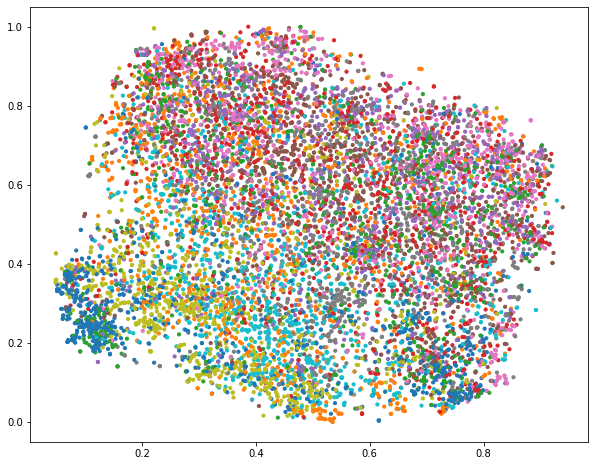

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_test[index]),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()